In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.datasets import cifar10

In [2]:
# Load CIFAR-10 dataset
(train_images, _), (_, _) = cifar10.load_data()

# Preprocess data
train_images = train_images.astype('float32') / 255.0
train_images_bw = tf.image.rgb_to_grayscale(train_images)

170498071/170498071 [==============================] - 4s 0us/step


In [3]:
# Generator network
def build_generator():
    model = models.Sequential()

    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', input_shape=[32, 32, 1]))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

In [4]:
generator = build_generator()

In [5]:
# Discriminator network
def build_discriminator():
    model = models.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [6]:
discriminator = build_discriminator()

In [7]:
# Loss function and optimizer
cross_entropy = losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)

In [8]:
# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [9]:
# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
# Define batch size
BATCH_SIZE = 132
EPOCHS = 300
noise_dim = 100

In [11]:
# Training loop
@tf.function
def train_step(images_bw, images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images_bw, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [12]:
# Training
for epoch in range(EPOCHS):
    for i in range(len(train_images) // BATCH_SIZE):
        batch_images = train_images[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
        batch_images_bw = train_images_bw[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]

        train_step(batch_images_bw, batch_images)

        print(f'Epoch {epoch+1}, Batch {i+1}/{len(train_images) // BATCH_SIZE}')

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Epoch 287, Batch 293/378
Epoch 287, Batch 294/378
Epoch 287, Batch 295/378
Epoch 287, Batch 296/378
Epoch 287, Batch 297/378
Epoch 287, Batch 298/378
Epoch 287, Batch 299/378
Epoch 287, Batch 300/378
Epoch 287, Batch 301/378
Epoch 287, Batch 302/378
Epoch 287, Batch 303/378
Epoch 287, Batch 304/378
Epoch 287, Batch 305/378
Epoch 287, Batch 306/378
Epoch 287, Batch 307/378
Epoch 287, Batch 308/378
Epoch 287, Batch 309/378
Epoch 287, Batch 310/378
Epoch 287, Batch 311/378
Epoch 287, Batch 312/378
Epoch 287, Batch 313/378
Epoch 287, Batch 314/378
Epoch 287, Batch 315/378
Epoch 287, Batch 316/378
Epoch 287, Batch 317/378
Epoch 287, Batch 318/378
Epoch 287, Batch 319/378
Epoch 287, Batch 320/378
Epoch 287, Batch 321/378
Epoch 287, Batch 322/378
Epoch 287, Batch 323/378
Epoch 287, Batch 324/378
Epoch 287, Batch 325/378
Epoch 287, Batch 326/378
Epoch 287, Batch 327/378
Epoch 287, Batch 328/378
Epoch 287, Batch 329/378
Epoch 287, Batch 3

In [13]:
# Save the model in native Keras format
tf.keras.models.save_model(generator, 'ColorTheImage.keras')

In [14]:
# Load the generator model
generator_Test = tf.keras.models.load_model('ColorTheImage.keras')

In [15]:
# Compile the model
generator_Test.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
def colorize_image(image_bw):
    try:
        # Convert the image to grayscale if it's not already
        if len(image_bw.shape) == 3 and image_bw.shape[2] == 3:
            image_bw = tf.image.rgb_to_grayscale(image_bw)

        # Ensure the image has only one channel
        if image_bw.shape[-1] != 1:
            raise ValueError("Input image should be a grayscale image")

        # Reshape the image to match the model's input shape
        image_bw = np.expand_dims(image_bw, axis=0)

        # Normalize the pixel values
        image_bw = image_bw.astype('float32') / 255.0

        # Generate the colorized image
        generated_image = generator_Test.predict(image_bw)

        # Denormalize the pixel values
        generated_image = generated_image * 255.0

        # Convert to uint8
        generated_image = generated_image.astype('uint8')

        return generated_image
    except Exception as e:
        print("Error in colorize_image:", str(e))
        return None

1/1 [==============================] - 0s 20ms/step


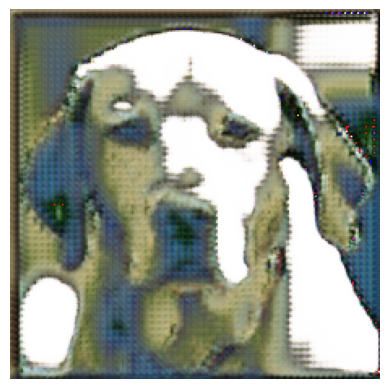

In [29]:
# Load your black and white image
bw_image = plt.imread('Dog.jpg')

# Colorize the black and white image
colorized_image = colorize_image(bw_image)

# Show the colorized image
plt.imshow(colorized_image[0])
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 21ms/step


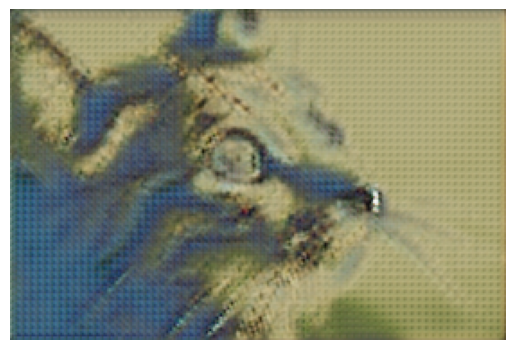

In [33]:
# Load your black and white image
bw_image = plt.imread('Cat.jpg')

# Colorize the black and white image
colorized_image = colorize_image(bw_image)

# Show the colorized image
plt.imshow(colorized_image[0])
plt.axis('off')
plt.show()